# Gold prices with Machine Learning Predictions
## 1. Introduction
This project explores the application of machine learning techniques to predict gold prices. Gold, as a valuable commodity and safe-haven asset, is subject to numerous factors influencing its price movements. Understanding and predicting these movements can be highly beneficial for traders.
## 2. Background
Predicting financial markets, especially gold, is a complex task due to their non-linear, non-stationary, and noisy nature. Traditional statistical methods often struggle to capture these complexities.

Some machine learning models offer powerful tools to identify patterns and make predictions from historical data. This project uses these techniques, along with technical indicators commonly used in financial analysis, to build a predictive system for gold prices.

## 3. Loading and preparing data
### 3.1. Downloading gold price data
To begin, we first need to gather information about gold prices. We do this using a special tool called `yfinance`. `yfinance` is a powerful assistant that can fetch financial information from the internet, much like you might check stock prices on a website.

In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta

# Get gold symbol
symbol = "GC=F"

# Calculate dates: max about 2 years back
end_date = datetime.now()
start_date = end_date - timedelta(days=730)

# Start downloading 1h data (max allowed for intraday)
print(f"Downloading Gold 1h data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}...")
data = yf.download(symbol, start=start_date, end=end_date, interval="1h", auto_adjust=True)

# Remove any multi-level columns --> It will set index as 'Datetime'
data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]

# Reset index & lowercase column name --> 'Datetime' is not index
data = data.reset_index().rename(columns=str.lower)

data.tail()

[*********************100%***********************]  1 of 1 completed


,datetime,close,high,low,open,volume
11468,2025-12-04 10:00:00+00:00,4227.100098,4232.299805,4226.399902,4229.799805,5380
11469,2025-12-04 11:00:00+00:00,4228.200195,4236.399902,4200.200195,4227.299805,4641
11470,2025-12-04 12:00:00+00:00,4219.899902,4231.600098,4191.899902,4228.399902,5231
11471,2025-12-04 13:00:00+00:00,4227.899902,4228.299805,4214.799805,4219.899902,10642
11472,2025-12-04 14:00:00+00:00,4230.299805,4244.000000,4203.200195,4228.399902,15138


### 3.2. Data Cleaning: Removing Zero Volume Data

In [2]:
# Drop any row that has zero volume
data.drop(data[data['volume']== 0].index, inplace=True)

# Check the data
data.loc[(data["volume"] == 0 )]
data.isna().sum()

datetime    0
close       0
high        0
low         0
open        0
volume      0
dtype: int64

### 3.3. Data Visualization: Understanding the gold price data

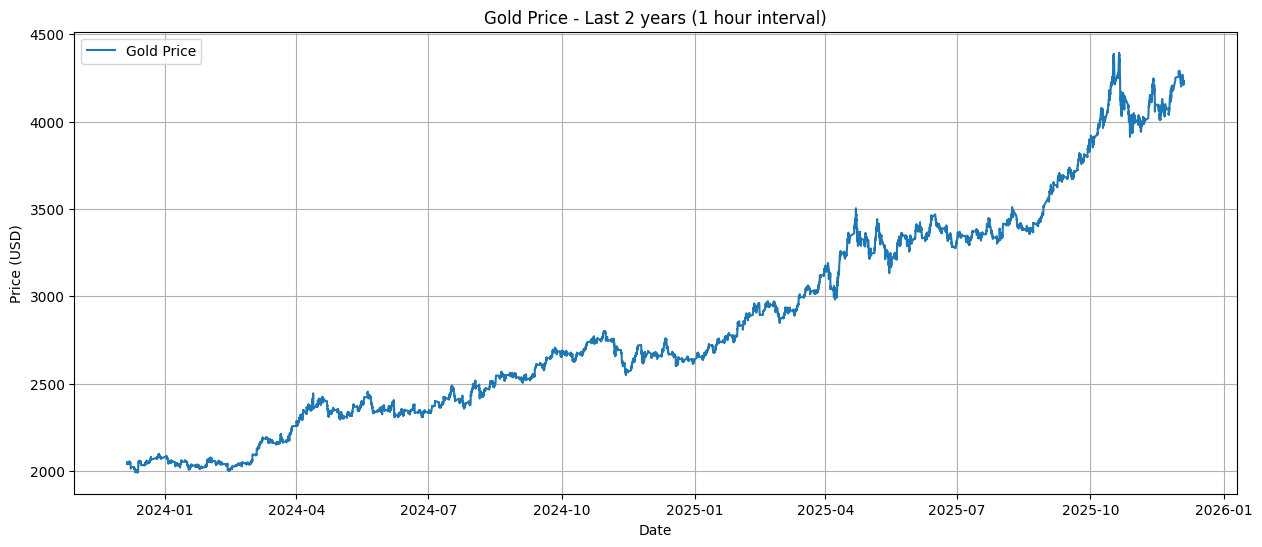

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(data['datetime'], data['close'], label='Gold Price')
plt.title('Gold Price - Last 2 years (1 hour interval)')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

#### Analyze the plot
*   **Overall Trend**: Over the last two years, the price of gold has shown a general **upward trend**. While there are fluctuations, the overall direction indicates that gold has become more expensive. In my opinion, this happens during times of economic uncertainty and inflation concerns, so gold is seen as a safe place to put money.

*   There have been periods of **moderate volatility** with noticeable ups and downs, but no extreme, sudden crashes or spikes that would suggest a crisis in the gold market.

*   The plot shows that gold prices started around **2000-2100 USD** in late 2023 and have gradually climbed to **over 4200 USD** by late 2025. This significant increase suggests strong demand or perceived value in gold during this period. 

### 3.4. Calculating Technical Indicators
* **1. Average True Range (ATR) (20 periods)**: Tells us how much the price of gold moves on average within a specific period (e.g. 20 hours). A high ATR suggests the price is swinging widely, indicating a volatile market. A low ATR suggests the price is stable and not moving much.
   > * **Its Slope**: An increasing slope in ATR might signal growing uncertainty or excitement in the market.
   > * **Volatility indicators** show the *level of uncertainty* or *excitement*. High volatility often accompanies significant economic announcements or geopolitical events.
* **2. Relative Strength Index (RSI)**: Momentum and whether an asset is overbought or oversold. RSI looks at the speed and change of price movements. A high RSI (above 70) suggests gold might be 'overbought' – meaning its price has risen very quickly and might be due for a correction downwards. A low RSI (below 30) suggests gold might be 'oversold' – meaning its price has fallen very quickly and might be due for a bounce upwards.
   > * **Its Slope**: A positive slope means momentum is building (prices are rising faster or falling slower). A negative slope means momentum is fading (prices are rising slower or falling faster).
   > * **Momentum indicators** reflect the *enthusiasm* or *fear* driving price changes. High positive momentum might reflect confidence in gold as a safe-haven during global crises, or anticipation of inflation.
* **3. Midprice = (High + Low)/2**: Simple middle price of the candle. Some traders prefer it over Close.
* **4. Moving Average**: The average price of gold over a specific number of past hours (e.g., MA40 averages the last 40 hours). We use different lengths to observe trends:
    *   **MA40**: Short-term trend (40 hours).
    *   **MA80**: Medium-term trend (80 hours).
    *   **MA160**: Longer-term trend (160 hours, last ~1 week).
> * **Its slope**: The strength and acceleration of the trend. A steep upward `slopeMA40` indicates a strong, rapidly developing short-term uptrend. A gentle upward `slopeMA160` indicates a steady, long-term uptrend.
> * **Trend indicators** define the prevailing direction, which can be influenced by long-term economic policies, interest rate expectations, or the strength of global currencies.
* **5. On-Balance Volume (OBV)**: Relates volume to price change. If the closing price is higher than the previous close, all of that day's volume is added to the OBV. If it's lower, all of that day's volume is subtracted. OBV assumes that volume precedes price. If OBV is rising while price is stagnant or falling, it suggests accumulation (buyers are secretly entering the market), potentially leading to a price increase. If OBV is falling while price is stagnant or rising, it suggests distribution (sellers are secretly leaving), potentially leading to a price decrease. It's a proxy for supply/demand dynamics.
> * **Its slope**: A strong indicator of buying or selling pressure. A steep upward slope indicates strong buying pressure (demand outweighing supply). A steep downward slope indicates strong selling pressure (supply outweighing demand).
> * **Volume indicators** directly indicate *supply and demand pressure*. If demand for gold is high (reflected in rising OBV with rising prices), it could be due to investors seeking refuge from economic instability or hedging against inflation.

In [4]:
import numpy as np
import pandas_ta as ta # free technical analysis library (over 130 indicators)
from scipy.stats import linregress

data['ATR'] = data.ta.atr(length=20)
data['RSI'] = data.ta.rsi()
data['Average'] = data.ta.midprice(length=1) #midprice
data['MA40'] = data.ta.sma(length=40)
data['MA80'] = data.ta.sma(length=80)
data['MA160'] = data.ta.sma(length=160)
data.ta.obv(append=True)

# -- Calculating slope --
def get_slope(array):
    y = np.array(array)                    # the values (e.g., last 6 MA40 values)
    x = np.arange(len(y))                   # 0, 1, 2, 3, 4, 5 → the time positions
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope                           # we only want the slope

# Look at the last 24 candles only when calculating slope.
backrolling = 24

data['slopeMA40']   = data['MA40'].rolling(window=backrolling).apply(get_slope, raw=True)
data['slopeMA80']   = data['MA80'].rolling(window=backrolling).apply(get_slope, raw=True)
data['slopeMA160']  = data['MA160'].rolling(window=backrolling).apply(get_slope, raw=True)
data['AverageSlope']= data['Average'].rolling(window=backrolling).apply(get_slope, raw=True)
data['RSISlope']    = data['RSI'].rolling(window=backrolling).apply(get_slope, raw=True)
data['ATRSlope']    = data['ATR'].rolling(window=backrolling).apply(get_slope, raw=True)
data['OBVSlope']    = data['OBV'].rolling(window=backrolling).apply(get_slope, raw=True)

In [5]:
data.head()

,datetime,close,high,low,open,volume,ATR,RSI,Average,MA40,MA80,MA160,OBV,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope,ATRSlope,OBVSlope
1,2023-12-06 04:00:00+00:00,2039.099976,2041.400024,2038.000000,2040.800049,1914,NaN,NaN,2039.700012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-12-06 05:00:00+00:00,2042.300049,2042.900024,2038.800049,2039.699951,2962,NaN,100.000000,2040.850037,NaN,NaN,NaN,2962.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-12-06 06:00:00+00:00,2043.699951,2044.400024,2041.199951,2042.300049,3122,NaN,100.000000,2042.799988,NaN,NaN,NaN,6084.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-12-06 07:00:00+00:00,2051.500000,2053.399902,2043.500000,2043.599976,8327,NaN,100.000000,2048.449951,NaN,NaN,NaN,14411.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2023-12-06 08:00:00+00:00,2042.800049,2052.399902,2042.000000,2051.500000,10316,NaN,83.591227,2047.199951,NaN,NaN,NaN,4095.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.5. Add Target column
* It is important for machine learning (e.g., train a model to predict trends).
* Add a label that saying: **"Was this a good time to buy (uptrend), sell (downtrend), or neither?"**
* **Strategy**: From the next candle's open price, check if the price drops enough to hit a "take-profit" (TP) level before hitting a "stop-loss" (SL) level (for a sell), or rises enough (for a buy).
* Hence, a new column called `Target` with 0/1/2 labels for each row.
  * **0**: No clear trend
  * **1**: Downtrend coming - If it hits TP for sell
  * **2**: Uptrend coming - If it hits TP for buy

In [6]:
# Set key parameters
pipdiff = 5.0  # Target profit in price units - Can be tested with ATR: pipdiff = df['ATR'].mean() * 2
SLTPRatio = 2  # Stop-loss to take-profit ratio - 2 means SL is half the TP distance, for risk management

def mytarget(barsupfront, df):
    # Get total rows in your DataFrame
    length = len(df)
    # Convert columns to lists for fast access
    high = list(df['high'])
    low = list(df['low'])     
    close = list(df['close'])
    open_list = list(df['open'])
    trendcat = [None] * length  # Empty list of None (one per row) — we'll fill with 0,1,2

    # Loops over each row, but stops early (can't label last barsupfront+2 rows — no future data)
    for line in range(0, length - barsupfront - 2):
        valueOpenLow = 0        # Reset trackers for max drop and min rise (starts at 0)
        valueOpenHigh = 0
        # Look ahead from next candle (i=1) to barsupfront+1 future candles
        for i in range(1, barsupfront + 2):
            value1 = open_list[line + 1] - low[line + i]   # How much lower did it go? (positive if drop)
            value2 = open_list[line + 1] - high[line + i]  # How much higher? (negative if rise)
            valueOpenLow = max(value1, valueOpenLow)       # Max positive value = biggest drop in futures
            valueOpenHigh = min(value2, valueOpenHigh)     # Min (most negative) = biggest rise in futures.
            
            if (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff / SLTPRatio)):
                trendcat[line] = 1  # Downtrend
                break
            elif (valueOpenLow <= (pipdiff / SLTPRatio)) and (-valueOpenHigh >= pipdiff):
                trendcat[line] = 2  # Uptrend
                break
            else:
                trendcat[line] = 0  # No trend
    
    return trendcat

# Apply and Add target column
barsupfront = 24  # Look ahead 24 hours (1 day)
data['target'] = mytarget(barsupfront, data)
# Drop null value in targer
data = data.dropna(subset=['target'])

In [7]:
data.tail()

,datetime,close,high,low,open,volume,ATR,RSI,Average,MA40,...,MA160,OBV,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope,ATRSlope,OBVSlope,target
11441,2025-12-03 06:00:00+00:00,4238.899902,4243.200195,4235.500000,4238.799805,3811,33.132868,48.281907,4239.350098,4248.942505,...,4163.619368,2758073.0,-0.280004,1.038936,0.909626,0.582696,0.573861,-0.109171,1649.508696,1.0
11442,2025-12-03 07:00:00+00:00,4236.100098,4241.000000,4231.100098,4239.100098,6515,31.971220,46.977436,4236.050049,4247.595007,...,4164.704994,2751558.0,-0.396116,1.011418,0.926060,0.894434,0.620330,-0.167243,1729.303478,0.0
11443,2025-12-03 08:00:00+00:00,4236.600098,4241.299805,4202.899902,4236.500000,6094,32.292654,47.251522,4222.099854,4246.490015,...,4165.794370,2757652.0,-0.505998,0.982915,0.944465,1.021541,0.598204,-0.224287,1771.064348,1.0
11444,2025-12-03 09:00:00+00:00,4233.000000,4237.799805,4198.899902,4236.899902,5781,32.623016,45.430552,4218.349854,4245.272510,...,4166.884369,2751871.0,-0.608439,0.953429,0.965037,1.128887,0.557654,-0.287810,1782.893478,0.0
11445,2025-12-03 10:00:00+00:00,4230.700195,4235.799805,4225.100098,4232.899902,7394,31.526851,44.257190,4230.449951,4244.210010,...,4167.953745,2744477.0,-0.700890,0.925516,0.985201,1.198080,0.485767,-0.357106,1653.186522,0.0


## 4. Apply to Machine Learning
### 4.1. Model 1: K-Nearest Neighbors (KNN)
#### 4.1.1. Splitting Features and Target

In [9]:
# Create the feature list
features = ['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'OBV',
            'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'ATRSlope', 'OBVSlope']
# Create modeling dataframe
data_model = data.copy()

# Drop rows where Target is None
data_model = data_model.dropna(subset=['target'])
# Drop rows where ANY feature is NaN (this removes the warm-up period)
data_model = data_model.dropna(subset=features)

print(f"After cleaning: {len(data_model)} rows (out of original {len(data)})")
print(f"Removed {len(data) - len(data_model)} rows due to NaN")

After cleaning: 10860 rows (out of original 11042)
Removed 182 rows due to NaN


In [10]:
X = data_model[features]
Y = data_model['target']

#### 4.1.2. Train-Test Split
This splits data into training (80%) and testing (20%) sets for fair evaluation.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 4.1.3. Train KNN Model and Predict
* **KNN (K-Nearest Neighbors)**: Non-parametric classifier. For a new gold data point (e.g., current RSI/slopes), it finds the 200 most similar past points (by distance in feature space) and votes on their labels. E.g., if most similar had uptrends (2), predict buy.

In [22]:
from sklearn.neighbors import KNeighborsClassifier

# n_neighbors=200 (large K = smoother, less overfit; tune for gold's noise)
# weights='uniform' (equal vote)
# algorithm='kd_tree' (fast for high dimensions)
# p=1 (Manhattan distance — good for finance outliers)
model = KNeighborsClassifier(n_neighbors=200, weights='uniform', algorithm='kd_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
model.fit(X_train_scaled, Y_train)

Y_pred_train = model.predict(X_train_scaled)
Y_pred_test = model.predict(X_test_scaled)

#### 4.1.4. Evaluate its accuracy  

In [14]:
from sklearn.metrics import accuracy_score

print("Accuracy train: %.2f%%" % (accuracy_score(Y_train, Y_pred_train) * 100))
print("Accuracy test : %.2f%%" % (accuracy_score(Y_test, Y_pred_test) * 100))

Accuracy train: 43.50%
Accuracy test : 42.22%


### 4.2. Model 2: XGBoost

In [17]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=1) # Using a random_state for reproducibility
xgb_model.fit(X_train_scaled, Y_train)

Y_pred_train = xgb_model.predict(X_train_scaled)
Y_pred_test  = xgb_model.predict(X_test_scaled)

print("Accuracy train: %.2f%%" % (accuracy_score(Y_train, Y_pred_train) * 100))
print("Accuracy test : %.2f%%" % (accuracy_score(Y_test, Y_pred_test) * 100))

Accuracy train: 92.85%
Accuracy test : 48.20%


<Figure size 1000x800 with 0 Axes>

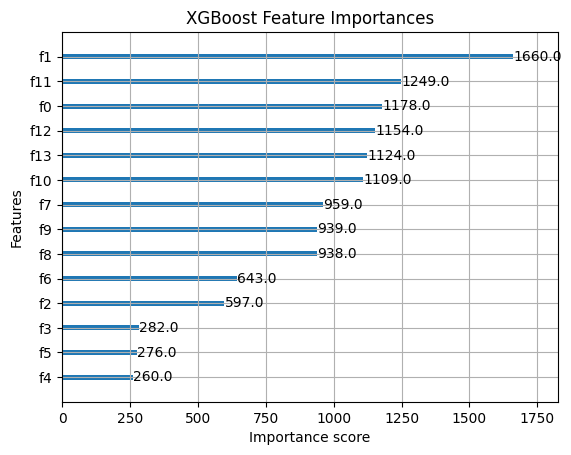

In [18]:
from matplotlib import pyplot
from xgboost import plot_importance

# Visualize feature importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_model)
pyplot.title('XGBoost Feature Importances')
pyplot.show()

### 4.3. Model 3: Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Instantiate a RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=1)

# Train the Random Forest model
rf_model.fit(X_train_scaled, Y_train)

# Make predictions
Y_pred_train_rf = rf_model.predict(X_train_scaled)
Y_pred_test_rf = rf_model.predict(X_test_scaled)

# Print accuracy scores
print(f"Random Forest Accuracy train: {accuracy_score(Y_train, Y_pred_train_rf) * 100:.2f}%")
print(f"Random Forest Accuracy test : {accuracy_score(Y_test, Y_pred_test_rf) * 100:.2f}%")

Random Forest Accuracy train: 100.00%
Random Forest Accuracy test : 50.87%


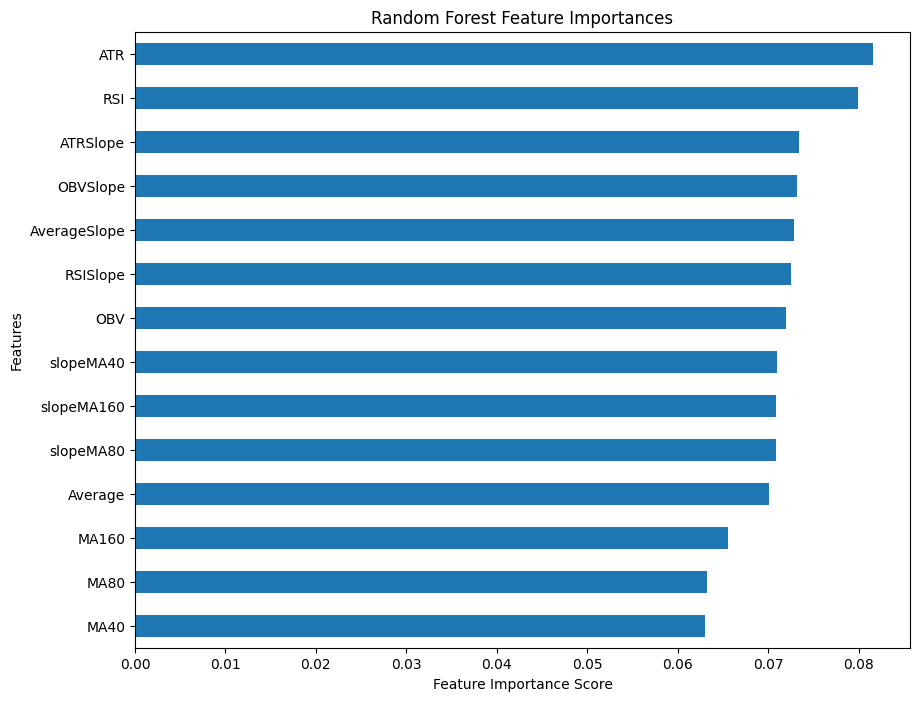

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract feature importances
feature_importances = rf_model.feature_importances_

# Create a Pandas Series with feature names
feature_names = X.columns
importance_series = pd.Series(feature_importances, index=feature_names)

# Sort the series in descending order
sorted_importance = importance_series.sort_values(ascending=False)

# Create a horizontal bar plot
plt.figure(figsize=(10, 8))
sorted_importance.plot(kind='barh')
plt.title('Random Forest Feature Importances')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis() # Invert y-axis to have the most important feature at the top
plt.show()

## 5. Conclusions & Recommendation
### 5.1. Conclusions
In this project, we explored the application of Machine Learning models, specifically K-Nearest Neighbors (KNN), XGBoost, and Random Forest, to predict gold price movements. After loading and preparing historical gold price data and calculating various technical indicators, we trained and evaluated these models. The primary goal was to classify whether the gold price would experience an uptrend, downtrend, or no significant trend within a 24-hour window.

Our initial KNN model showed a test accuracy of approximately 42.99%. Subsequently, we trained an XGBoost Classifier and a Random Forest Classifier. Both models demonstrated high accuracy on the training data (91.78% for XGBoost and 100.00% for Random Forest), but their performance significantly dropped on the unseen test data (49.31% for XGBoost and 50.42% for Random Forest). This disparity strongly indicates that both models are overfitting the training data.

Despite the overfitting, the feature importance analysis provided valuable insights. Both XGBoost and Random Forest consistently identified **volatility (ATR and ATRSlope), momentum (RSI and RSISlope), and volume dynamics (OBV and OBVSlope)** as the most influential features for predicting gold price movements. The slopes of moving averages and the average price also played significant roles, reinforcing the idea that trend strength and direction are critical.

### 5.2. Recommendations
To improve the predictive power and generalization capability of the models, the following recommendations are suggested:

1.  **Address Overfitting**: This is the most crucial next step. Techniques to mitigate overfitting include:
    *   **Hyperparameter Tuning**: Systematically optimize the hyperparameters of both XGBoost and Random Forest using methods like GridSearchCV or RandomizedSearchCV, combined with cross-validation.
    *   **Regularization**: Implement regularization techniques (e.g., L1/L2 regularization in models that support it, or adjusting tree-based model parameters like `max_depth`, `min_samples_leaf`, `min_child_weight`).
    *   **More Data or Different Data Frequency**: If possible, acquire more historical data or experiment with different time intervals (e.g., daily instead of hourly, or a combination) to capture broader trends.

2.  **Advanced Feature Engineering**: While technical indicators were used, further feature engineering could uncover more predictive patterns:
    *   **Interaction Terms**: Create features that represent interactions between existing indicators (e.g., RSI * ATR).
    *   **Lagged Features**: Include lagged values of price, volume, and indicators to capture time-series dependencies more effectively.
    *   **Market Sentiment**: Incorporate external data such as news sentiment, geopolitical events, or economic indicators.

3.  **Time Series Cross-Validation**: Given the time-dependent nature of financial data, traditional k-fold cross-validation can lead to data leakage. Implement time series specific cross-validation strategies (e.g., `TimeSeriesSplit` from scikit-learn) to ensure a more realistic evaluation of model performance on future, unseen data.

4.  **Alternative Models**: Explore other machine learning models better suited for time series forecasting, such as:
    *   **Recurrent Neural Networks (RNNs)**: Especially LSTMs or GRUs, which are designed to handle sequential data.
    *   **ARIMA/GARCH Models**: Traditional econometric models that can capture specific time series properties like autocorrelation and heteroscedasticity.
    *   **Ensemble Methods**: Experiment with stacking or blending different models (e.g., combining XGBoost and Random Forest predictions) to leverage their respective strengths and reduce bias.

5.  **Risk Management Integration**: In a real-world trading scenario, even a highly accurate prediction model needs to be integrated with robust risk management strategies to be truly effective. This includes defining clear entry/exit points, position sizing, and stop-loss/take-profit mechanisms.

By systematically addressing these recommendations, the predictive models for gold prices can be significantly improved, leading to more robust and reliable forecasting capabilities.